In [101]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import countDistinct
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
import pyspark.ml.evaluation as evals
import pyspark.ml.tuning as tune

In [91]:
import pandas as pd
import seaborn as sns

In [ ]:
spark = SparkSession \
    .builder \
    .appName("Apprentissage de Pyspark par la pratique") \
    .getOrCreate()

22/11/12 21:21:41 WARN Utils: Your hostname, cniongolo.local resolves to a loopback address: 127.0.0.1; using 192.168.1.182 instead (on interface en0)
22/11/12 21:21:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/12 21:21:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [74]:
def rename_cols(dataframe, colname, replace_name):
    """Rename columns in a dataframe"""
    df = dataframe.withColumnRenamed(colname, replace_name)
    return df

In [18]:
spark.version

'3.3.1'

In [ ]:
conso_elec_gaz_annuelle = spark.read.option("delimiter", ";").csv("datasets/conso-elec-gaz-annuelle-par-secteur-dactivite-agregee-departement.csv", header=True, inferSchema=True)

In [19]:
conso_elec_gaz_annuelle.take(5)

[Row(operateur='Enedis', annee=2011, filiere='Electricité', consoa=28496.17, pdla=280, nombre_maille_secretisees_a=0, indquala=0.943, consoi=1180989.65, pdli=1412, nombre_maille_secretisees_i=0, indquali=0.964, consot=737572.47, pdlt=3040, nombre_maille_secretisees_t=0, indqualt=0.932, consor=1977574.54, pdlr=313211, nombre_maille_secretisees_r=0, indqualr=0.303, consona=37947.56, pdlna=39, nombre_maille_secretisees_na=0, indqualna=0.829, code_departement='01', libelle_departement='Ain', code_region=84, libelle_region='Auvergne-Rhône-Alpes', id_filiere=100, geom=None, consototale=3962580.39),
 Row(operateur='Enedis', annee=2011, filiere='Electricité', consoa=5096.35, pdla=66, nombre_maille_secretisees_a=0, indquala=0.86, consoi=348627.93, pdli=893, nombre_maille_secretisees_i=0, indquali=0.903, consot=2104796.95, pdlt=8006, nombre_maille_secretisees_t=0, indqualt=0.923, consor=4113958.18, pdlr=823968, nombre_maille_secretisees_r=1, indqualr=0.354, consona=12681.93, pdlna=134, nombre_ma

In [87]:
conso_elec_gaz_annuelle.describe().toPandas()

,summary,operateur,annee,filiere,consoa,pdla,nombre_maille_secretisees_a,indquala,consoi,pdli,...,pdlna,nombre_maille_secretisees_na,indqualna,code_departement,libelle_departement,code_region,libelle_region,id_filiere,geom,consototale
0,count,5592,5592,5592,5592,5592,5592,5592,5592,5592,...,5592,5592,5592,5592,5592,5592,5592,5592,0,5592
1,mean,None,2016.3381616595136,None,14512.841888996118,234.8555078683834,13.733726752503577,0.37879250715307644,671009.9336184345,428.995886981402,...,930.5552575107296,17.505185979971387,0.3970157188841201,57.261844938980616,None,55.45046494992847,None,140.5579399141631,None,1756165.7006845707
2,stddev,None,3.0631444507701424,None,42027.79924930926,881.0425026509444,51.224938939618475,0.4422498195311602,1954358.765006391,1204.733523341051,...,10805.932820396758,63.732752040328315,1.93186431136818,88.58857259512406,None,25.733497467928412,None,49.10477270917986,None,2878701.231656631
3,min,Antargaz-Finagaz,2011,Electricité,0.0,0,0,0.0,0.0,0,...,0,0,0.0,01,Ain,1,Auvergne-Rhône-Alpes,100,None,0.0
4,max,Vialis,2021,Gaz,467701.0,8590,462,1.0,2.909840296E7,40962,...,448854,853,100.0,976,Yvelines,94,Île-de-France,200,None,2.909840296E7


In [88]:
conso_elec_gaz_annuelle.describe(["consototale"]).show()

+-------+------------------+
|summary|       consototale|
+-------+------------------+
|  count|              5592|
|   mean|1756165.7006845707|
| stddev| 2878701.231656631|
|    min|               0.0|
|    max|     2.909840296E7|
+-------+------------------+



In [20]:
conso_elec_gaz_annuelle.printSchema()

root
 |-- operateur: string (nullable = true)
 |-- annee: integer (nullable = true)
 |-- filiere: string (nullable = true)
 |-- consoa: double (nullable = true)
 |-- pdla: integer (nullable = true)
 |-- nombre_maille_secretisees_a: integer (nullable = true)
 |-- indquala: double (nullable = true)
 |-- consoi: double (nullable = true)
 |-- pdli: integer (nullable = true)
 |-- nombre_maille_secretisees_i: integer (nullable = true)
 |-- indquali: double (nullable = true)
 |-- consot: double (nullable = true)
 |-- pdlt: integer (nullable = true)
 |-- nombre_maille_secretisees_t: integer (nullable = true)
 |-- indqualt: double (nullable = true)
 |-- consor: double (nullable = true)
 |-- pdlr: integer (nullable = true)
 |-- nombre_maille_secretisees_r: integer (nullable = true)
 |-- indqualr: double (nullable = true)
 |-- consona: double (nullable = true)
 |-- pdlna: integer (nullable = true)
 |-- nombre_maille_secretisees_na: integer (nullable = true)
 |-- indqualna: double (nullable = true

In [49]:
conso_elec_gaz_annuelle.columns

['operateur',
 'annee',
 'filiere',
 'consoa',
 'pdla',
 'nombre_maille_secretisees_a',
 'indquala',
 'consoi',
 'pdli',
 'nombre_maille_secretisees_i',
 'indquali',
 'consot',
 'pdlt',
 'nombre_maille_secretisees_t',
 'indqualt',
 'consor',
 'pdlr',
 'nombre_maille_secretisees_r',
 'indqualr',
 'consona',
 'pdlna',
 'nombre_maille_secretisees_na',
 'indqualna',
 'code_departement',
 'libelle_departement',
 'code_region',
 'libelle_region',
 'id_filiere',
 'geom',
 'consototale']

In [40]:
by_operator = conso_elec_gaz_annuelle.groupBy("operateur")
by_operator.count().show()

+--------------------+-----+
|           operateur|count|
+--------------------+-----+
|Energies et servi...|    5|
|           SICAE ELY|   17|
|Régie municipale ...|    4|
|Régie électrique ...|    7|
|Régie électrique ...|    4|
|         Gaz de Barr|   16|
|Régie électrique ...|    2|
|SICAE de la vallé...|    7|
|Régie municipale ...|    4|
|Régie municipale ...|   15|
|              Séolis|    4|
|Régie d'électrici...|    3|
|Coopérative d'éle...|   11|
|    Régie SDED Erôme|    3|
|Régie du syndicat...|   18|
|Régie municipale ...|    1|
|Régie électrique ...|    7|
|Régie électriques...|    4|
|                 SRD|   48|
|Régie municipale ...|   11|
+--------------------+-----+
only showing top 20 rows



In [42]:
by_departments = conso_elec_gaz_annuelle.groupBy("libelle_departement")
by_departments.count().show()

+-------------------+-----+
|libelle_departement|count|
+-------------------+-----+
|Pyrénées-Orientales|   81|
|               Gers|   41|
|              Yonne|   43|
|             Allier|   43|
|              Drôme|   58|
|     Indre-et-Loire|   56|
|   Bouches-du-Rhône|   43|
|          Finistère|   46|
|            Aveyron|   46|
|               Gard|   43|
|         Val-d'Oise|   50|
|               Eure|   49|
|  Seine-Saint-Denis|   43|
|              Indre|   55|
|               Nord|   90|
| Meurthe-et-Moselle|   52|
|             Guyane|   10|
|             Lozère|   21|
|               Jura|   50|
|           Calvados|   47|
+-------------------+-----+
only showing top 20 rows



## Créer une vue en ce basant sur le dataframe

In [54]:
conso_elec_gaz_annuelle.createOrReplaceTempView("conso_elec_gaz_annuelle") 

In [56]:
# SQL test
avg_consommation_annuel = spark.sql('SELECT avg(consoa) FROM conso_elec_gaz_annuelle').collect()[0]
print('The average consommation time is: %d' % avg_consommation_annuel)

The average consommation time is: 14512


## Rêquete SQL de type SELECT

In [62]:
all_entries = spark.sql("SELECT * FROM conso_elec_gaz_annuelle")
all_entries.toPandas()

,operateur,annee,filiere,consoa,pdla,nombre_maille_secretisees_a,indquala,consoi,pdli,nombre_maille_secretisees_i,...,pdlna,nombre_maille_secretisees_na,indqualna,code_departement,libelle_departement,code_region,libelle_region,id_filiere,geom,consototale
0,Enedis,2011,Electricité,28496.17,280,0,0.943,1.180990e+06,1412,0,...,39,0,0.829,01,Ain,84,Auvergne-Rhône-Alpes,100,None,3.962580e+06
1,Enedis,2011,Electricité,5096.35,66,0,0.860,3.486279e+05,893,0,...,134,0,0.562,06,Alpes-Maritimes,93,Provence-Alpes-Côte d'Azur,100,None,6.585161e+06
2,Enedis,2011,Electricité,5209.86,50,0,0.926,4.032235e+05,550,0,...,20,0,0.729,07,Ardèche,84,Auvergne-Rhône-Alpes,100,None,1.771009e+06
3,Enedis,2011,Electricité,2701.12,88,0,0.986,1.089328e+05,183,0,...,67,0,0.893,09,Ariège,76,Occitanie,100,None,7.057527e+05
4,Enedis,2011,Electricité,2392.61,34,0,0.903,2.467442e+05,488,0,...,16,0,0.711,19,Corrèze,75,Nouvelle-Aquitaine,100,None,1.403873e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5587,Teréga,2021,Gaz,0.00,0,0,0.000,4.183070e+05,6,0,...,0,0,0.000,11,Aude,76,Occitanie,200,None,4.192237e+05
5588,Teréga,2021,Gaz,0.00,0,0,0.000,0.000000e+00,0,0,...,0,0,0.000,12,Aveyron,76,Occitanie,200,None,8.797556e+03
5589,Teréga,2021,Gaz,0.00,0,0,0.000,1.401172e+05,6,0,...,0,0,0.000,47,Lot-et-Garonne,75,Nouvelle-Aquitaine,200,None,1.528131e+05
5590,Teréga,2021,Gaz,0.00,0,0,0.000,6.244044e+05,8,0,...,0,0,0.000,64,Pyrénées-Atlantiques,75,Nouvelle-Aquitaine,200,None,7.586903e+05


## Aperçu de la Consommation totale par `libelle_departement`, `operateur`, `annee`, `filiere`, `conso agricole`

In [65]:
# Select the columns of interest
conso_elec_gaz_annuelle.select('libelle_departement', 'operateur', 'annee', 'filiere', 'consoa', 'consototale').show(200)

+--------------------+--------------------+-----+-----------+---------+--------------------+
| libelle_departement|           operateur|annee|    filiere|   consoa|         consototale|
+--------------------+--------------------+-----+-----------+---------+--------------------+
|                 Ain|              Enedis| 2011|Electricité| 28496.17|          3962580.39|
|     Alpes-Maritimes|              Enedis| 2011|Electricité|  5096.35|          6585161.34|
|             Ardèche|              Enedis| 2011|Electricité|  5209.86|          1771008.98|
|              Ariège|              Enedis| 2011|Electricité|  2701.12|   705752.6699999999|
|             Corrèze|              Enedis| 2011|Electricité|  2392.61|          1403872.63|
|           Côte-d'Or|              Enedis| 2011|Electricité| 10297.88|           2999355.1|
|               Drôme|              Enedis| 2011|Electricité| 47817.92|  2971144.0199999996|
|        Eure-et-Loir|              Enedis| 2011|Electricité|101767.48

In [96]:
conso_elec_gaz_annuelle.select(
    'libelle_departement', 'operateur', 'annee', 'filiere', 'consoa', 'consoi' ,'consototale'
).distinct().show(100)

+--------------------+--------------------+-----+-----------+----------------+----------------+--------------------+
| libelle_departement|           operateur|annee|    filiere|          consoa|          consoi|         consototale|
+--------------------+--------------------+-----+-----------+----------------+----------------+--------------------+
|       Côtes-d'Armor|             GRT Gaz| 2011|        Gaz|             0.0|       226335.66|           226335.66|
|   Seine-Saint-Denis|              Enedis| 2014|Electricité|         1033.53|       456311.43|          6393502.88|
|             Moselle|Energies et servi...| 2014|Electricité|             0.0|             0.0|             76324.0|
|              Ariège|Régie municipale ...| 2015|Electricité|             0.0|             0.0|              3236.0|
|                Aude|              Enedis| 2016|Electricité|        17424.26|       209481.89|          2070759.71|
|       Côtes-d'Armor|              Enedis| 2016|Electricité|   

In [104]:
# Make the avg of the consototale by distinct libelle_departement
conso_elec_gaz_annuelle.select(
    'libelle_departement', 'operateur', 'annee', 'filiere', 'consoa', 'consoi' ,'consototale'
).distinct().groupBy('libelle_departement').avg('consototale').show(100)

+--------------------+--------------------+
| libelle_departement|    avg(consototale)|
+--------------------+--------------------+
| Pyrénées-Orientales|   724446.2604788449|
|                Gers|  422116.20758011634|
|              Allier|   1662777.049698313|
|               Yonne|  1100522.3774720188|
|               Drôme|  1351064.5520670349|
|      Indre-et-Loire|  1392324.6751723897|
|    Bouches-du-Rhône|1.1628600891994901E7|
|           Finistère|   2484555.242741952|
|             Aveyron|   637934.0885216534|
|                Gard|  1961623.4973479835|
|          Val-d'Oise|  2692803.2847428448|
|                Eure|  1681281.1748168636|
|   Seine-Saint-Denis|   4413474.008146862|
|               Indre|   586900.6133071801|
|                Nord|    6943305.63785174|
|              Guyane|         801722.4762|
|  Meurthe-et-Moselle|  3578606.0141292284|
|              Lozère|   247349.3289889385|
|            Calvados|  1873030.6792954595|
|                Jura|  1218541.

In [99]:
# Nombre de datas dans le dataframe
conso_elec_gaz_annuelle.distinct().count()

5592

## Consommation éléctrique du département du Val-De-Marne

In [85]:
conso_elec_gaz_annuelle.filter(
    (conso_elec_gaz_annuelle['filiere'] == 'Electricité') & (conso_elec_gaz_annuelle['libelle_departement'] == "Val-de-Marne")
).select('libelle_departement', 'operateur', 'annee', 'filiere', 'consoa', 'consoi' ,'consototale').where(
    conso_elec_gaz_annuelle['consototale'] > 10000
).toPandas()

,libelle_departement,operateur,annee,filiere,consoa,consoi,consototale
0,Val-de-Marne,Enedis,2011,Electricité,1033.850000,373641.940000,5.609901e+06
1,Val-de-Marne,Enedis,2012,Electricité,1005.310000,387451.080000,5.837323e+06
2,Val-de-Marne,RTE,2016,Electricité,0.000000,303266.870000,6.013959e+05
3,Val-de-Marne,Enedis,2018,Electricité,1277.961290,521586.636736,5.654163e+06
4,Val-de-Marne,Coopérative d'électricité de Villiers sur Marne,2019,Electricité,0.000000,2040.000000,7.364700e+04
5,Val-de-Marne,Coopérative d'électricité de Villiers sur Marne,2020,Electricité,0.000000,0.000000,6.248616e+04
6,Val-de-Marne,Enedis,2020,Electricité,1772.988275,554374.308898,5.433954e+06
7,Val-de-Marne,Enedis,2021,Electricité,1611.091239,594847.341380,5.592655e+06
8,Val-de-Marne,Enedis,2013,Electricité,823.820000,400529.770000,5.998992e+06
9,Val-de-Marne,RTE,2013,Electricité,0.000000,320445.400000,6.377903e+05


In [105]:
conso_elec_gaz_annuelle.select(countDistinct("libelle_departement")).show()

+-----------------------------------+
|count(DISTINCT libelle_departement)|
+-----------------------------------+
|                                101|
+-----------------------------------+



## Consommation sur l'année 2021

In [69]:
conso_2021 = conso_elec_gaz_annuelle.filter(
    conso_elec_gaz_annuelle.annee == 2021
)

In [93]:
# rename_cols(conso_2021, "consoa", "conso_agricole").select("conso_agricole").show()

In [84]:
conso_2021.select("consoa").show()

+----------------+
|          consoa|
+----------------+
|        5983.888|
|             0.0|
|             0.0|
|        3727.287|
|         786.545|
| 20578.142510889|
| 18072.676954196|
| 33165.116182009|
| 83680.507691814|
|115371.972311297|
| 85429.085295045|
| 92862.930666965|
| 52569.336157585|
| 86362.298398166|
|229503.481697773|
| 46946.418025096|
|146728.751222897|
|178700.579836063|
| 91300.801266699|
| 18162.790820229|
+----------------+
only showing top 20 rows



## La moyenne de conso totale 

In [90]:
conso_elec_gaz_annuelle.agg(
    {
        "consototale" : "mean"
    }
).show()

+------------------+
|  avg(consototale)|
+------------------+
|1756165.7006845707|
+------------------+



## Visualisation des données

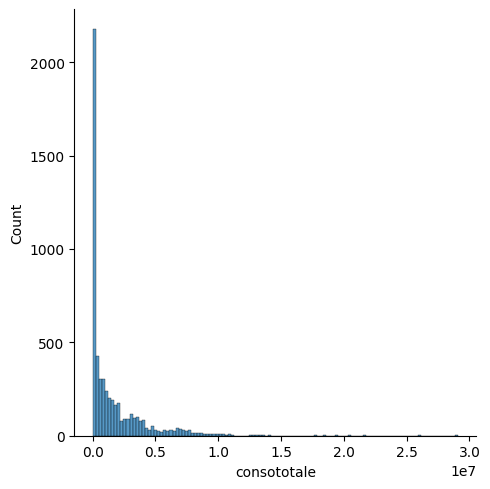

In [132]:
sns.displot(conso_elec_gaz_annuelle.toPandas(), x="consototale")

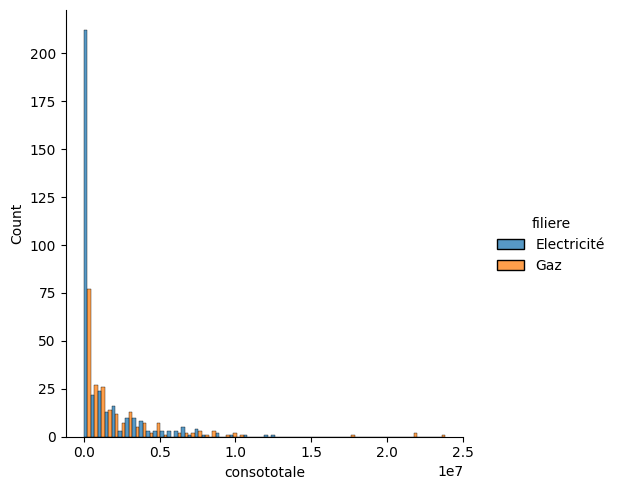

In [128]:
sns.displot(
    conso_2021.toPandas(),
    x="consototale",
    hue="filiere", 
    multiple="dodge",
)